In [ ]:
import pandas as pd
from utils.plotting import plot_time, plot_sep, plot_trajectories

**Read results**

In [ ]:
TASK = "income"
STATE = "CA"
DATASET = TASK + "_" + STATE
DATASET = TASK + "_" + STATE
loaded_models = []

experiments_to_read = {
    'SGD': {
        'unconstrained': 0.01
    },
    # 'sgd-nonsep': {
    #     'unconstrained': 0
    # },
    # 'ssg_sep': {
    #     # 'abs_loss_equality': 0.02,
    #     # 'tpr_equality': 0.05,
    #     "abs_diff_tpr": 0.02,
    #     "abs_diff_fpr": 0.02,
    # },
    # 'sslalm_sep': {
    #     # 'abs_loss_equality': 0.02,
    #     # 'tpr_equality': 0.05,
    #     "abs_diff_tpr": 0.02,
    # },
    'SSG': {
        "abs_diff_tpr": 0.02,
        "abs_max_dev_from_overall_tpr": 0.02
    },
    'TorchSSLALM': {
        # 'abs_loss_equality': 0.02,
        # 'tpr_equality': 0.05,
        "abs_diff_tpr": 0.02,
        # "abs_max_dev_from_overall_tpr": 0.02
    },
    'SSLALM': {
        # 'abs_loss_equality': 0.02,
        # 'tpr_equality': 0.05,
        "abs_diff_tpr": 0.02,
        # "abs_max_dev_from_overall_tpr": 0.02
    },
    'ssg': {
        # 'abs_loss_equality': 0.02,
        # 'tpr_equality': 0.05,
        "abs_diff_tpr": 0.02,
        # "abs_max_dev_from_overall_tpr": 0.02
    }
}

In [ ]:
from itertools import product
import os

# names = product(alg_list, constr_list, lb_list)
alg_states = {}
full_eval_train = {}
full_eval_test = {}

for alg, con in experiments_to_read.items():
    for constraint, bound in con.items():
        FILE_EXT = ".pt"
        dir = f"./utils/exp_results/{constraint}"

        filename_state = os.path.join(dir, f"{alg}_" + f"{DATASET}_{bound}.csv")
        filename_full_train = os.path.join(dir, f"AFTER_{alg}_" + f"{DATASET}_{bound}_train.csv")
        filename_full_test = os.path.join(dir, f"AFTER_{alg}_" + f"{DATASET}_{bound}_test.csv")
        try:
            data_state = pd.read_pickle(filename_state).reset_index()
            data_full_train = pd.read_pickle(filename_full_train).reset_index()
            data_full_test = pd.read_pickle(filename_full_test).reset_index()

            alg_states['__'.join([alg, constraint, str(bound)])] = data_state
            full_eval_train['__'.join([alg, constraint, str(bound)])] = data_full_train
            full_eval_test['__'.join([alg, constraint, str(bound)])] = data_full_test

            print(f'loaded {alg} | {constraint} | {bound}')
        except FileNotFoundError: 
            print(f'not found {alg} | {constraint} | {bound} at {dir}')

not found SGD_mar | unconstrained | 0.01 at ./utils/exp_results/unconstrained
loaded SSG | abs_diff_tpr | 0.02
not found SSG | abs_max_dev_from_overall_tpr | 0.02 at ./utils/exp_results/abs_max_dev_from_overall_tpr
loaded TorchSSLALM | abs_diff_tpr | 0.02
loaded SSLALM | abs_diff_tpr | 0.02
not found ssg | abs_diff_tpr | 0.02 at ./utils/exp_results/abs_diff_tpr


In [ ]:
import numpy as np


def explode_column(df, col, names, m):
    df[names] = list(
        df[col].map(
                    lambda x: [np.nan]*m if np.all(np.isnan(x)) else x 
                    )
        )

def aggregate_stats(live_stats, after_stats, constraint_bound):
    """
    live_stats: states of the algorithm evaluated during run
    after_stats: statistics evaluated on full set after run
    """
    live_stats.columns = live_stats.columns.map(lambda x: str(x) + '_live' if x == 'c' else x)
    after_stats.columns = after_stats.columns.map(lambda x: str(x) + '_full' if x == 'c' else x)
    # combine into one dataframe
    stats_joined = after_stats.set_index(['iteration', 'trial']).join(live_stats.set_index(['iteration', 'trial']), on=['iteration', 'trial'], how='inner',lsuffix='_full', rsuffix='_live')
    for col in stats_joined.columns:
        # change [list] into list
        if isinstance(stats_joined[col].iloc[0], list):
            stats_joined[col] = stats_joined[col].map(lambda x: x[0] if not np.all(np.isnan(x)) else x)
        # "explode" ndarray column into separate columns
        if isinstance(stats_joined[col].iloc[0], np.ndarray):
            if len(stats_joined[col].iloc[0].shape) == 1 and col in ['c_live', 'c_full']:
                m = len(stats_joined[col].iloc[0])
            
                explode_column(stats_joined, col, [f'{col}{i}' for i in range(m)], m)
                for i in range(m):
                    stats_joined[f'{col}{i}_corrected'] = stats_joined[f'{col}{i}'] + constraint_bound

            # add norm for ndarray columns
            stats_joined[f'{col}_norm'] = stats_joined.apply(lambda x: np.linalg.norm(x[col]),axis=1)

    stats_joined.dropna(axis=0, how='all', inplace=True, subset=[x for x in stats_joined.columns if x not in ['cb', 'time', 'constraint_name']])

    # convert one-element ndarrays into floats
    for col in stats_joined.columns:
        if isinstance(stats_joined[col].iloc[0], np.ndarray):
            if stats_joined[col].iloc[0].ndim == 0 or stats_joined[col].iloc[0].ndim == 1 and stats_joined[col].iloc[0].shape[0] == 1:
                stats_joined[col] = stats_joined[col].astype(float)

    stats_joined.reset_index(drop=False, inplace=True)

    return stats_joined


data_train = {}
data_test = {}

for name in full_eval_train.keys():
    data_train[name] = aggregate_stats(alg_states[name], full_eval_train[name], float(name.split('__')[-1]))
    data_test[name] = aggregate_stats(alg_states[name], full_eval_test[name], float(name.split('__')[-1]))

---
---
**Plot w.r.t. time**

In [ ]:
from utils.plotting import plot_time
from matplotlib import pyplot as plt

# alg_name = 'SGD',
# alg_name = 'sgd-nonsep'
alg_name = 'TorchSSLALM'
# alg_name = 'ssg_sep'
# alg_name = 'sslalm_sep'
# alg_name = 'sslalm'
# alg_name = 'ssg_sep'
# c = "unconstrained"
# c = "tpr_equality"
# c = "abs_max_dev_from_overall_tpr"
c = "abs_diff_tpr"
# c = "abs_diff_fpr"
cb = 0.02
alg = f"{alg_name}__{c}__{cb}"
data = data_train[alg]

fl = plot_time(
    data,
    cb,
    loss_col='f_full',
    c_col='c_full0_corrected',
    two_sided=True,
    round_step=0.01,
    f_ylim=(0.35, 0.77),
    c_ylim=(-0.2, 0.2),
    sep_figs=False,
    add_lb=False,
    q1=0.25,
    q2=0.75,
    plot_loss=True
)

ValueError: arange: cannot compute length

---


**Plot trajectories of each run w.r.t. iterations**

/home/andre/humancompatible/humancompatible-train/experiments/utils/plotting.py:71: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


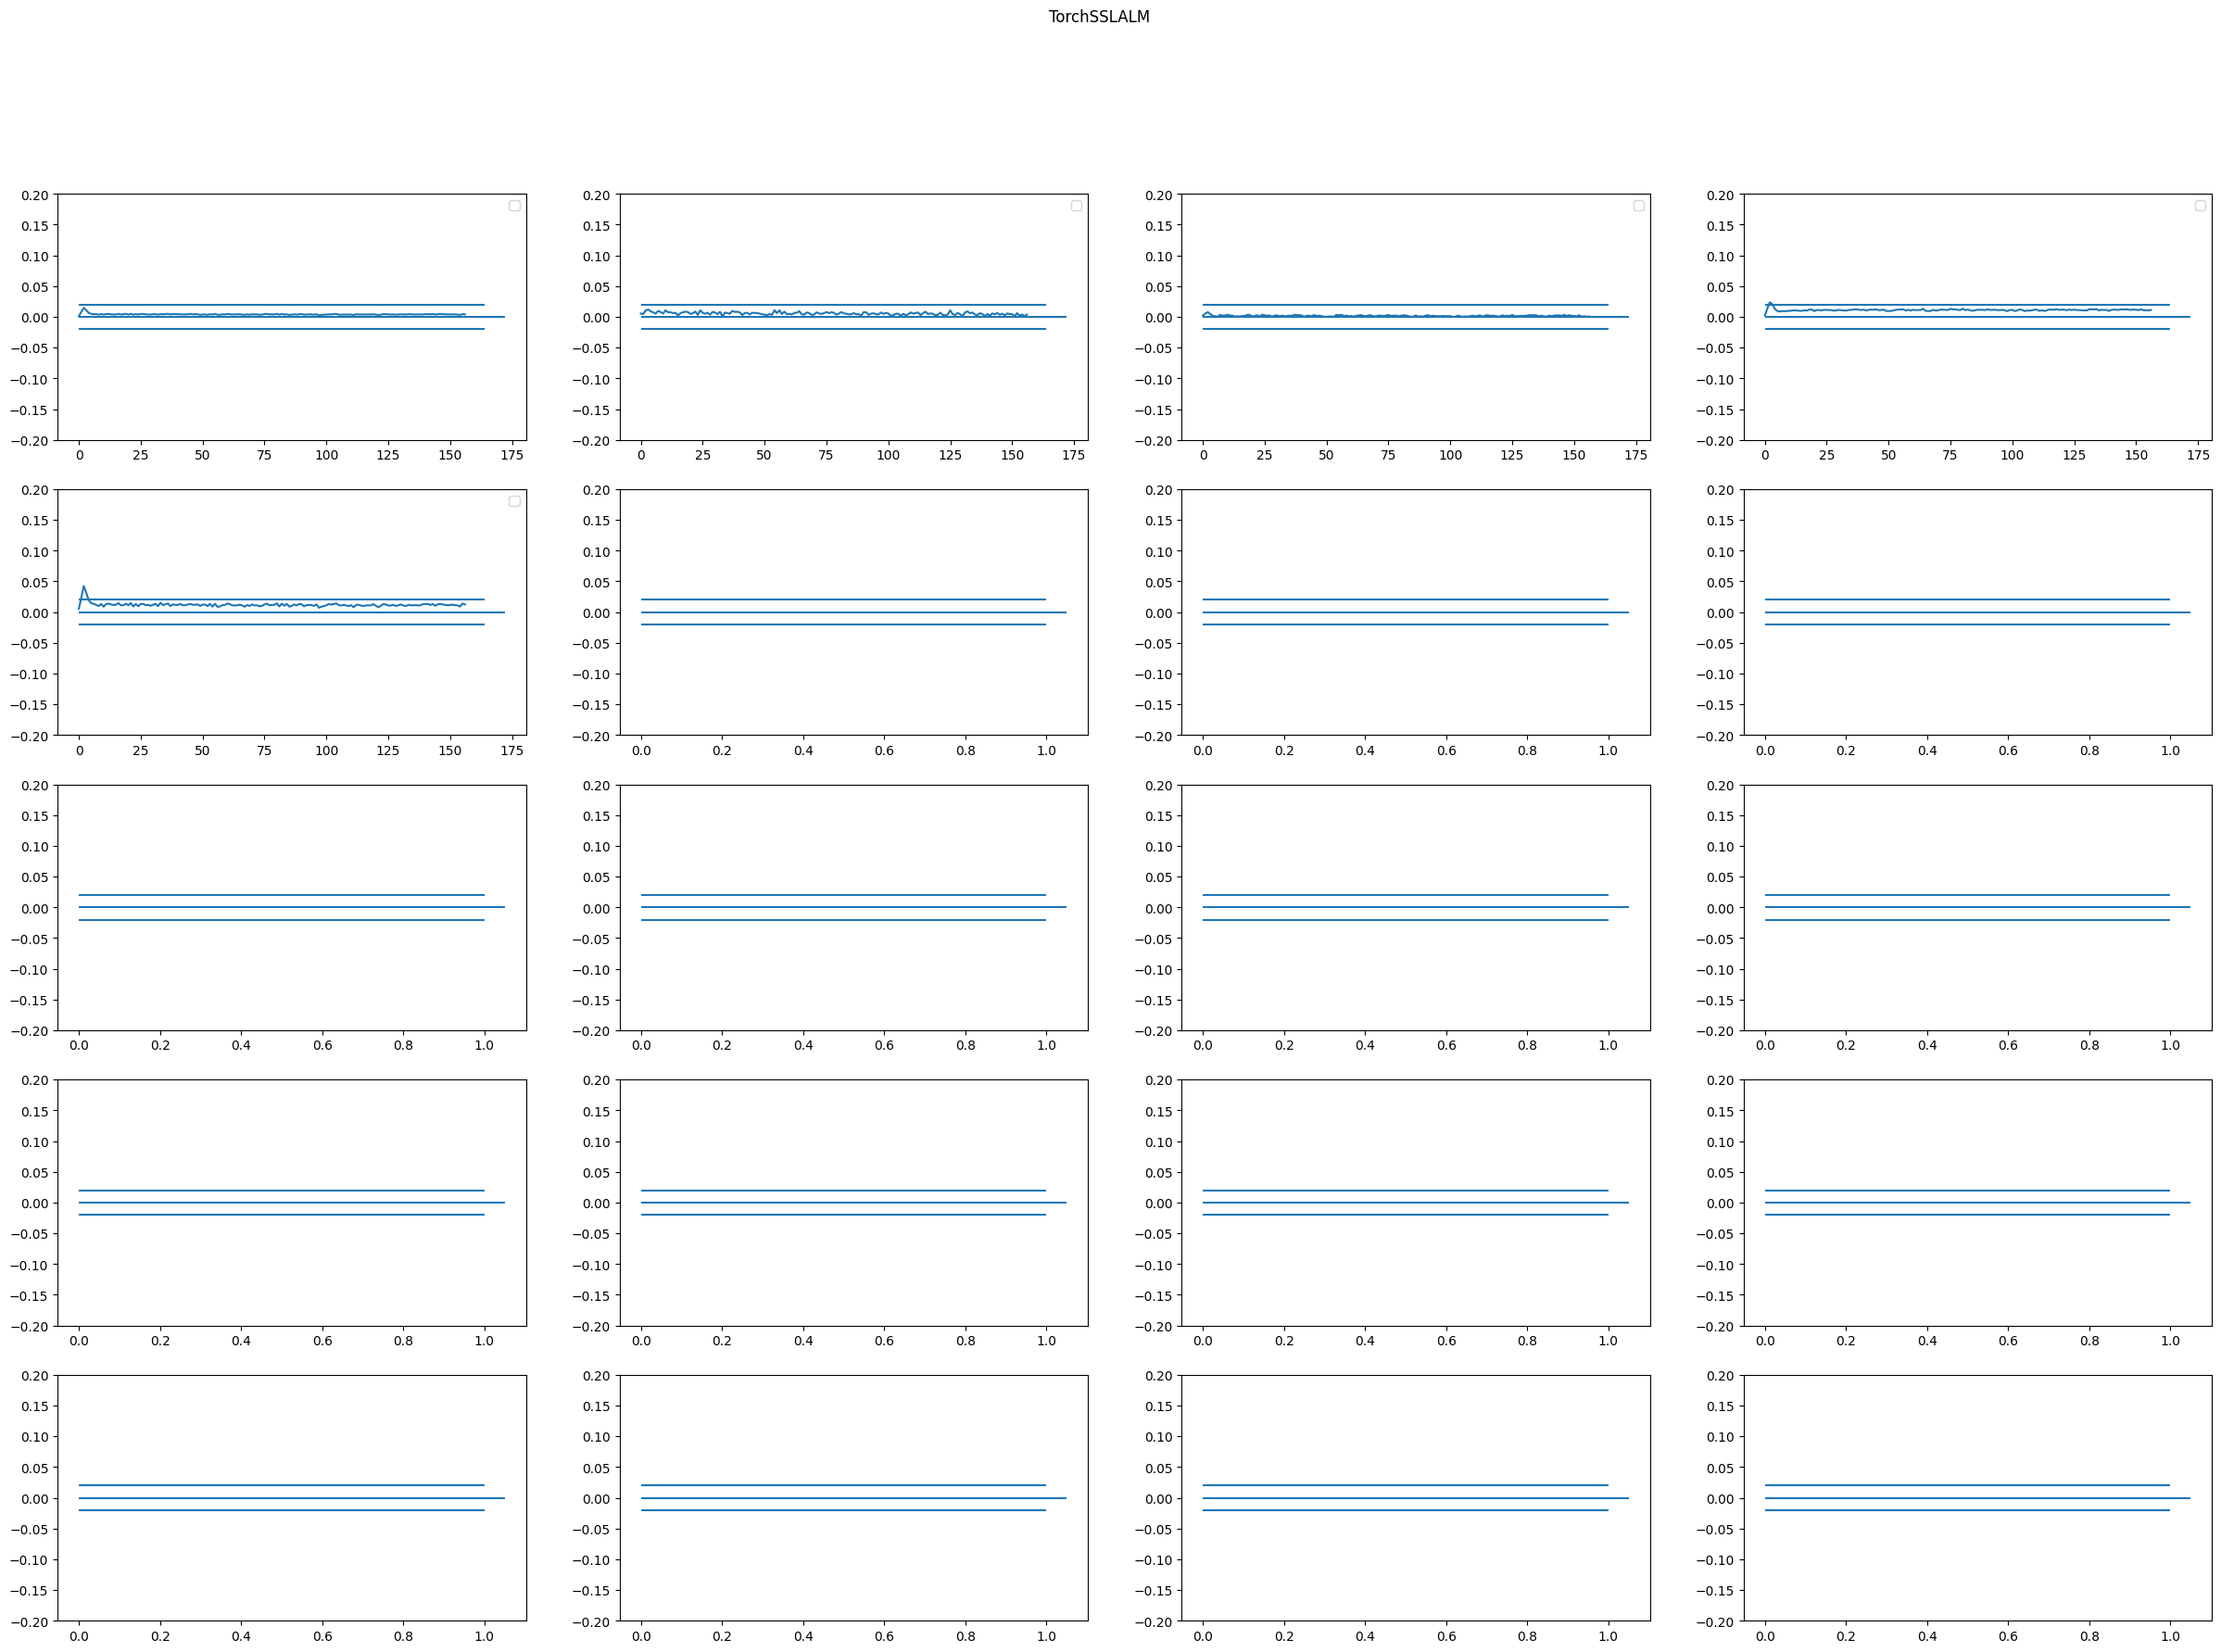

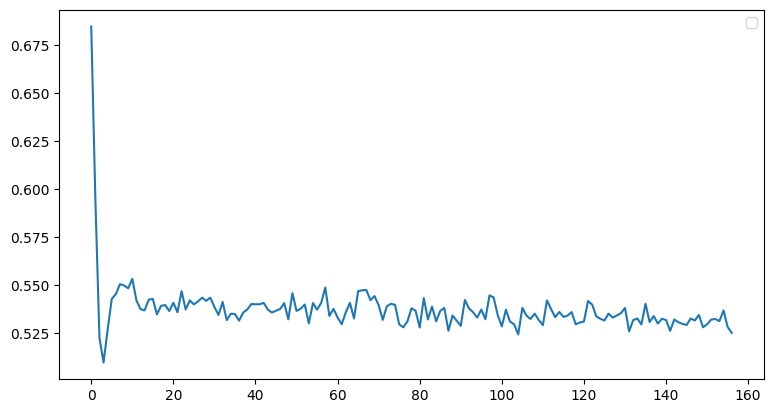

In [ ]:
from utils.plotting import plot_sep
from matplotlib import pyplot as plt

alg = f"{alg_name}__{c}__{cb}"
data = data_train[alg]

f, ax = plt.subplots(5,4)
if isinstance(ax, plt.Axes):
    ax = [ax]
ax_f = plot_sep(data, plot_col='f_full', idx_col='trial')
ax_f.set_figwidth(20)
for i, ax in enumerate(f.axes):
    try:
        plot_sep(data, plot_col=f'c_full{i}_corrected', idx_col='trial', ax=ax)
    except:
        break
f.set_figwidth(30)
f.set_figheight(20)
f.suptitle(alg_name)
for a in f.axes:
    a.hlines((-cb, cb), 0, a.get_xbound()[1])
    a.hlines(0, 0, a.get_xbound()[1])
    a.set_ylim((-0.01*20, 0.01*20))